# Trabalho 4 - Operações Geométricas

## Scanner doméstico usando um celular.

Os filhos do professor de visão computacional são aficionados por Star Wars. O maiorzinho queria uma imagem de um storm trooper como plano de fundo para o seu tablet. Contudo, o scanner de casa está quebrado e o salário do professor está muito atrasado. O pior é que o governador Pezão nem sequer diz quando vai pagar os três salário em atraso. Como a grana está curta, o professor resolveu usar câmera do celular. No entanto, é sabido que a imagem obtida pela câmera impõe à imagem original uma geometria projetiva e esta distorção precisa ser compensada já que o garoto ficou muito triste com a qualidade do resultado obtido pela câmera. Felizmente, como o pai dos meninos é professor, ele propôs que seus alunos da Uerj resolvessem este problema como trabalho para a disciplina. Para facilitar a tarefa, o professor fotografou a imagem do storm trooper sobre uma folha de papel A4 que serve como referência. Obtenha a transformação projetiva que recupere a geometria da imagem original e reconstrua-a usando a interpolação bilinear. Veja a seguir a imagem de entrada.

Faça toda a álgebra linear manualmente, das bibliotecas usadas no curso, você só pode usar as funções  ```imread``` e ```imwrite```.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance as dist

In [2]:
np.set_printoptions(threshold = np.nan)

-------

#### Definição de Funções

In [3]:
def img2binary(img, threshold = 60):
    """Binarization of image with threshold given"""
    return threshold < img

In [4]:
def roberts(img):
    """Apply Roberts filter to image"""
    k_robertsx = np.array([[1, 0], [0, -1]])
    k_robertsy = np.array([[0, 1], [-1, 0]])
    robertsx = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(k_robertsx, -1)))
    robertsy = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(k_robertsy, -1)))
    
    return robertsx + robertsy

In [5]:
def binary_roberts(img, threshold = 60):
    """Returns roberts image in binary scale"""
    return img2binary(roberts(img), threshold).astype(np.uint8)

In [6]:
def clockwise_sort(points):
    tl = points[np.argsort(points[:, 0]), :][0]
    points = np.delete(points, np.where(np.all(points == tl, axis = 1)), axis = 0)
    bl = points[np.argsort(points[:, 1]), :][0]
    points = np.delete(points, np.where(np.all(points == bl, axis = 1)), axis = 0)
    tr = points[np.argsort(points[:, 0]), :][0]
    br = points[(points != tr)[:, 0]][0]
    
    return np.array([tl, tr, br, bl], dtype = np.int)

In [7]:
def detect_corners(img):
    """Detect corners based on non zero pixel of image object borders"""
    b = np.where(img > 0)
    p1 = np.array([b[0][np.argmin(b[0])], b[1][np.argmin(b[0])]])
    p2 = np.array([b[0][np.argmax(b[1])], b[1][np.argmax(b[1])]])
    p3 = np.array([b[0][np.argmax(b[0])], b[1][np.argmax(b[0])]])
    p4 = np.array([b[0][np.argmin(b[1])], b[1][np.argmin(b[1])]])
    p5 = np.array([b[1].min(), b[0].min()])
    p6 = np.array([b[1].min(), b[0].max()])
    p7 = np.array([b[1].max(), b[0].max()])
    p8 = np.array([b[1].max(), b[0].min()])
    
    corners = np.array([p1, p2, p3, p4, p5, p6, p7, p8])
    
    return np.unique(corners[img[corners[:,0], corners[:,1]] == 1], axis = 0)

In [8]:
def cornerfy_from_file(filein, fileout = ''):
    imgin = cv.imread(filein, 0)
    roberts_binary = binary_roberts(imgin)
    corners = detect_corners(roberts_binary)
#     save_image_with_corners(imgin, corners, fileout)
    return roberts_binary, clockwise_sort(corners)

In [9]:
def cornerfy_from_array(arrayin, fileout = ''):
    roberts_binary = binary_roberts(arrayin)
    corners = detect_corners(roberts_binary)
#     save_image_with_corners(arrayin, corners, fileout)
    return roberts_binary, clockwise_sort(corners)

In [10]:
def true_corners(img, corners):
    for i in range(len(corners)):
        if img[tuple(corners[i])] == 0:
            ind = tuple(corners[i])
            idx = np.argwhere(img)
            idx = idx[~(idx == ind).all(1)]
            corners[i] = idx[((idx - ind)**2).sum(1).argmin()]
    
    return clockwise_sort(corners)

In [11]:
def transformation_coefficients(img_in, img_out):
    A = np.zeros

-------

## Figuras/Imagens

Lê a figura do Stormtrooper

In [12]:
stormtrooper = cv.imread('../images/IMG_20170615_082455.jpg', 0)

Cria o painel do A4 em branco (sem intensidade nos pixels)

In [13]:
# A4 para 150 ppi
# A4 totalmente branco
A4 = np.zeros((1754, 1240), dtype = np.uint8)

Cria um losango

In [14]:
diamond = np.uint8([[(30 <= x + y) & (10 >= -x + y) & (-10 <= -x + y) & (50 >= x + y) for y in range(41)] for x in range(41)]) * 255

Cria um quadrado

In [15]:
square = np.uint8([[(x >= 10) & (x <= 30) & (y >= 10) & (y <= 30) for y in range(41)] for x in range(41)]) * 255

------

## Teste da Identificação dos Cantos

Usando as imagens do losango e do quadrado vamos testar o algoritmo para identificar os cantos da imagem.

In [16]:
diamond_roberts, diamond_corners = cornerfy_from_array(diamond)
diamond_corners = true_corners(diamond, diamond_corners)

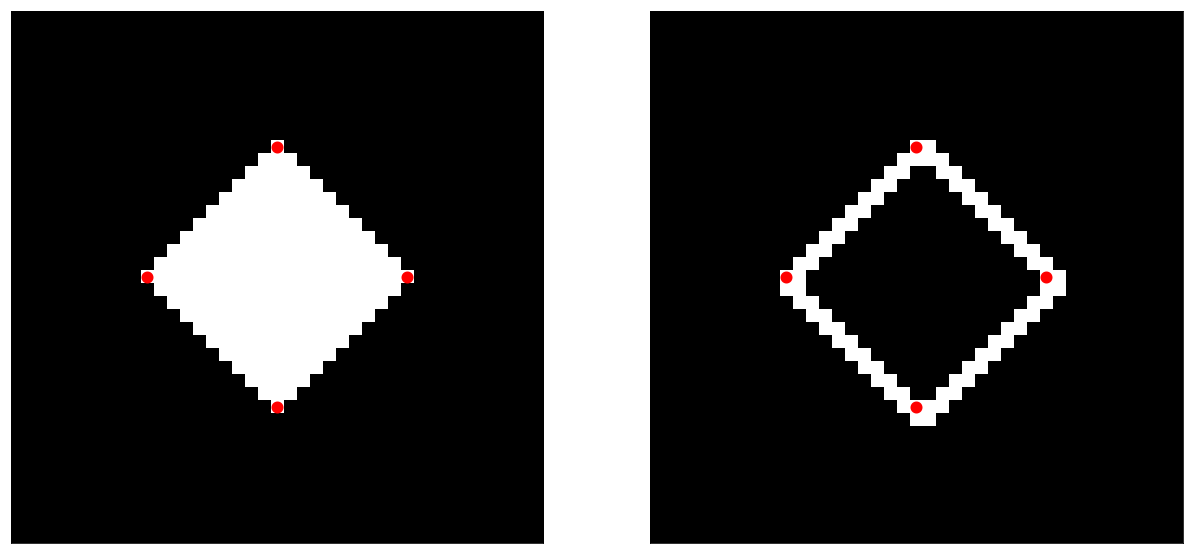

In [17]:
fig = plt.figure(figsize = (21,15))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(diamond, cmap = 'gray')
ax.scatter(diamond_corners[:,1], diamond_corners[:,0], marker = 'o', color = 'red', linewidths = 6)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(1, 2, 2)
ax.imshow(diamond_roberts, cmap = 'gray')
ax.scatter(diamond_corners[:,1], diamond_corners[:,0], marker = 'o', color = 'red', linewidths = 6)
plt.xticks([])
plt.yticks([])

plt.show()

In [18]:
square_roberts, square_corners = cornerfy_from_array(square)
square_corners = true_corners(square, square_corners)

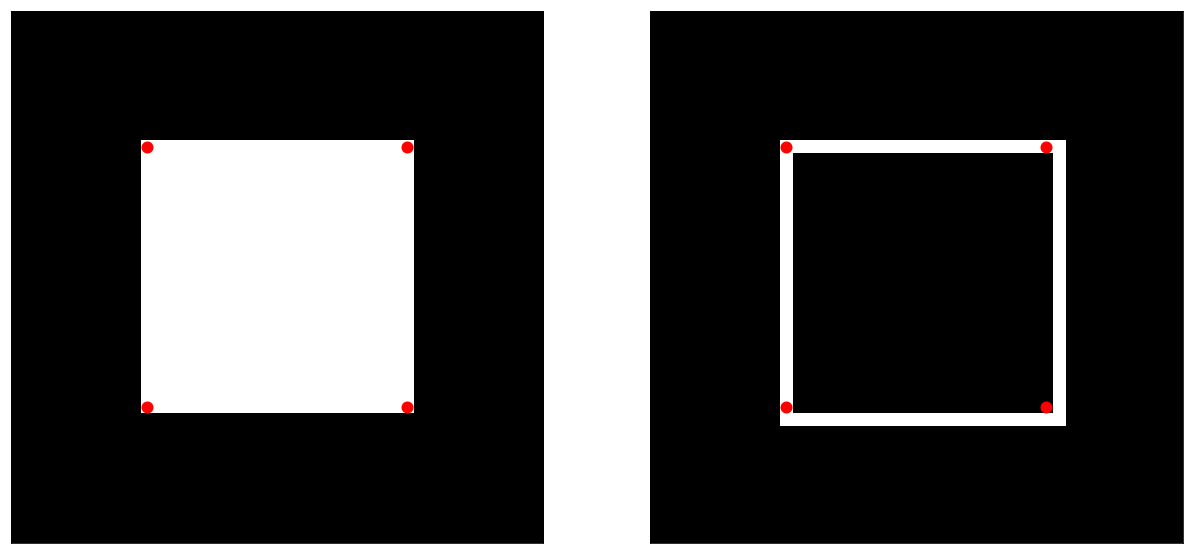

In [19]:
fig = plt.figure(figsize = (21,15))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(square, cmap = 'gray')
ax.scatter(square_corners[:,1], square_corners[:,0], marker = 'o', color = 'red', linewidths = 6)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(1, 2, 2)
ax.imshow(square_roberts, cmap = 'gray')
ax.scatter(square_corners[:,1], square_corners[:,0], marker = 'o', color = 'red', linewidths = 6)
plt.xticks([])
plt.yticks([])
plt.show()

plt.show()

In [20]:
stormtrooper_roberts, stormtrooper_corners = cornerfy_from_array(stormtrooper)
stormtrooper_corners = true_corners(stormtrooper, stormtrooper_corners)

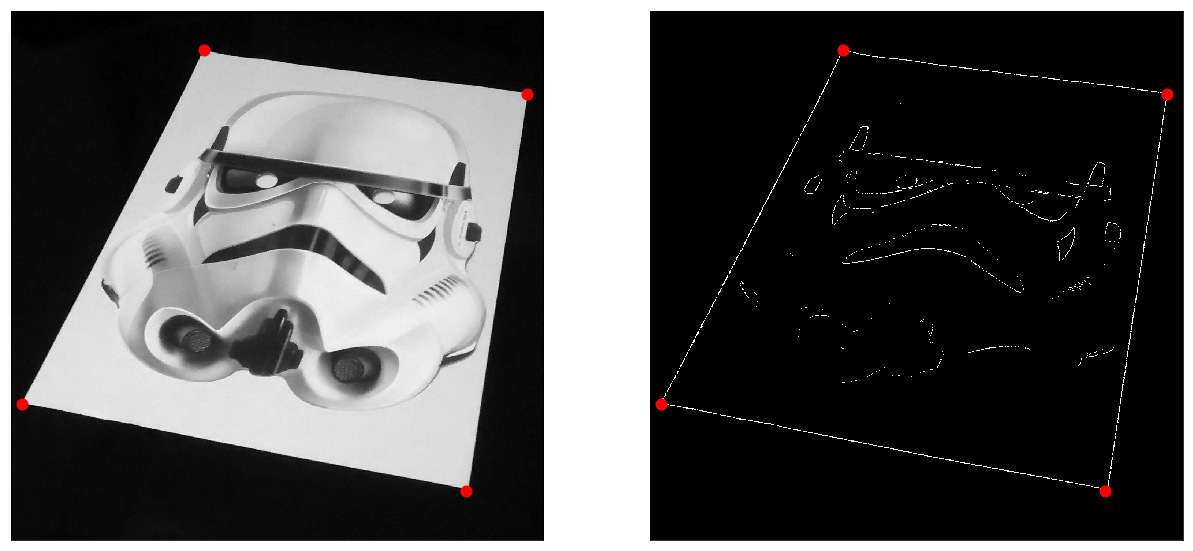

In [21]:
fig = plt.figure(figsize = (21,15))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(stormtrooper, cmap = 'gray')
ax.scatter(stormtrooper_corners[:,1], stormtrooper_corners[:,0], marker = 'o', color = 'red', linewidths = 6)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(1, 2, 2)
ax.imshow(stormtrooper_roberts, cmap = 'gray')
ax.scatter(stormtrooper_corners[:,1], stormtrooper_corners[:,0], marker = 'o', color = 'red', linewidths = 6)
plt.xticks([])
plt.yticks([])
plt.show()

plt.show()

In [22]:
A4_corners = np.array([[0,0], [0, 1240], [1754, 0], [1754, 1240]])
A4_corners = clockwise_sort(A4_corners)

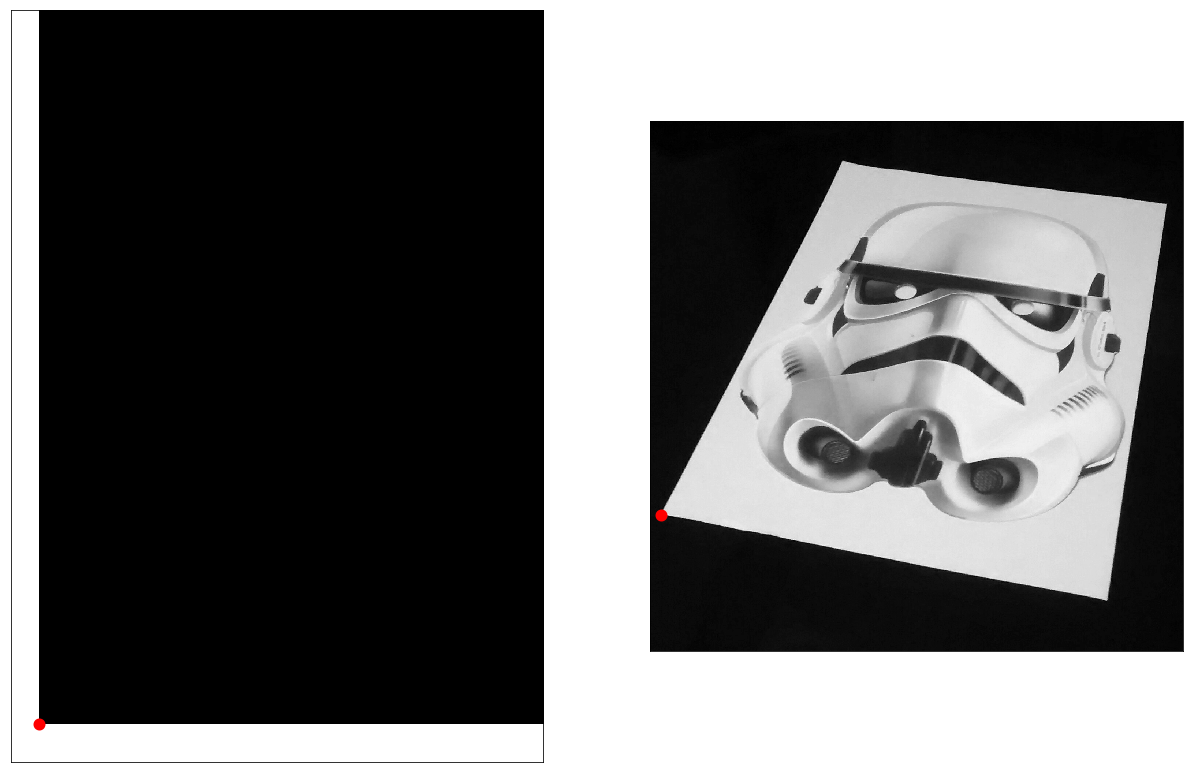

In [23]:
point = 3

fig = plt.figure(figsize = (21,15))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(A4, cmap = 'gray')
ax.scatter(A4_corners[point,1], A4_corners[point,0], marker = 'o', color = 'red', linewidths = 6)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(1, 2, 2)
ax.imshow(stormtrooper, cmap = 'gray')
ax.scatter(stormtrooper_corners[point,1], stormtrooper_corners[point,0], marker = 'o', color = 'red', linewidths = 6)
plt.xticks([])
plt.yticks([])


plt.show()

In [24]:
print(stormtrooper_corners)
print(A4_corners)

[[ 107  527]
 [ 227 1412]
 [1312 1245]
 [1076   31]]
[[   0    0]
 [   0 1240]
 [1754 1240]
 [1754    0]]


In [30]:
1240 * 1245

1543800

In [31]:
A = np.array([
    [107, 527, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 107, 527, 1, 0, 0],
    [227, 1412, 1, 0, 0, 0, 0, -1750880],
    [0, 0, 0, 227, 1412, 1, 0, -1750880],
    [1312, 1245, 1, 0, 0, 0, -2301248, -1543800],
    [0, 0, 0, 1312, 1245, 1, -2301248, -1543800],
    [1076, 31, 1, 0, 0, 0, -1887304, 0],
    [0, 0, 0, 1067, 31, 1, -1887304, 0]
])

In [48]:
L = np.array([0, 0, 0, 1240, 1754, 1240, 1754, 0]).reshape([8,1])

In [53]:
X = np.linalg.inv(A.T @ A) @ A.T @ L

In [55]:
X

array([[-3.89614906e+01],
       [-6.62309321e+00],
       [ 7.65924961e+03],
       [-4.03337828e+01],
       [-5.03588975e+00],
       [ 6.96962865e+03],
       [-1.91927904e-02],
       [-6.01801172e-03]])

In [67]:
stormtrooper_corners.reshape(-1, 1).shape[1]

1

In [69]:
def transformation_matrix(in_corners, out_corners):
    if in_corners.shape[1] != 1:
        in_corners = in_corners.reshape(-1, 1)
    if out_corners.shape[1] != 1:
        out_corners = out_corners.reshape(-1, 1)
    
    A = np.zeros((len(in_corners), 8))

    for i in range(0, len(in_corners), 2):
        for j in range(0, len(A.shape[1])):
            if (i % 2 == 0) and (j in [3, 4, 5]):
                A[i, j] == 0
            else:
                A[i, j]  
            if ((i + 1) % 2 != 0) and (j in [0, 1, 2]):
                A[i + 1, j] == 0
            
        

In [70]:
transformation_matrix(stormtrooper_corners, A4_corners)

0
2
4
6
